# INET 4061 Final Project
# Twitter Prediction

### Evan Ditter and Thomas Tang

## Overview
Social Media has become a medium that people all over the world use to communicate and show off what they have been doing. Ranging from the very business oriented LinkedIn to the silly Tik Tok videos, Social Media has become a place where businesses are trying to put their foot in to get the younger generations aware.

This project will explore using classification to begin with on a person's tweets to find out how much traffic they may get. By traffic, we mean likes, retweets, followers, tweet.id, number of tweets, and any other twitter metadata from the Twitter API. From a individual's perspective, these measures will help you get the largest sphere of influence. From a business perspective the larger your influence, the more marketing you can get for your business. 

We will start out with scraping Twitter's API for tweets and perform classification on the tweets to see how easy it is to distinguish someone's twitter fame.

**References:**  
https://twitter.com/Predict_Popular  
https://www.promptcloud.com/blog/scrape-twitter-data-using-python-r/  
https://programminghistorian.org/en/lessons/counting-frequencies  
https://www.earthdatascience.org/courses/earth-analytics-python/using-apis-natural-language-processing-twitter/get-and-use-twitter-data-in-python/  

## Data

In [1]:
import tweepy as tw
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np

import json
import csv

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import linear_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn import tree
from sklearn import model_selection
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier

from textblob import TextBlob
import string
import preprocessor as p

In [2]:
with open('twitter_credentials.json') as cred_data:
    info = json.load(cred_data)
    consumer_key = info['CONSUMER_KEY']
    consumer_secret = info['CONSUMER_SECRET']
    access_key = info['ACCESS_KEY']
    access_secret = info['ACCESS_SECRET']

In [3]:
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret)
api = tw.API(auth, wait_on_rate_limit=True)

The above code establishes twitter developer credentials and lots of the imports we will be using.  

Below is the biggest code segment we had to create which went through our accounts following and got all the tweets from the users. We tried to get a random generation of famous and "not famous" people such that there is a relatively equal number of tweets from the two sections. 

In [4]:
data_col = []
def get_all_tweets(screen_name):
    #Twitter only allows access to a users most recent 3240 tweets with this method
    #authorize twitter, initialize tweepy
    auth = tw.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_key, access_secret)
    api = tw.API(auth)

    #initialize a list to hold all the tweepy Tweets
    alltweets = []
    #make initial request for most recent tweets (200 is the maximum allowed count)
    new_tweets = api.user_timeline(screen_name = screen_name,count=200)
    #save most recent tweets
    alltweets.extend(new_tweets)

    #save the id of the oldest tweet less one
    oldest = alltweets[-1].id - 1

    #keep grabbing tweets until there are no tweets left to grab
    while len(new_tweets) > 0:
        print("getting tweets before %s" % (oldest))

        #all subsiquent requests use the max_id param to prevent duplicates
        new_tweets = api.user_timeline(screen_name = screen_name,count=200,max_id=oldest)
                
        #save most recent tweets
        alltweets.extend(new_tweets)
        
        #update the id of the oldest tweet less one
        oldest = alltweets[-1].id - 1

        print("...%s tweets downloaded so far" % (len(alltweets)))

#     #transform the tweepy tweets into a 2D array that will populate the csv
#     outtweets = [[tweet.id_str, tweet.created_at, tweet.text.encode("utf-8")] for tweet in alltweets]

        for tweet in alltweets:
            if (not tweet.retweeted) and ('RT @' not in tweet.text):
                if 'media' in tweet.entities:
                    type = 0
                else:
                    type = 1
                if tweet in data_col:
                    return
                else:
                    data_col.append([tweet.id,
                                     tweet.text,
                                     tweet.user.name,
                                     len(tweet.text), 
                                     tweet.user.statuses_count, 
                                     tweet.user.favourites_count, 
                                     tweet.user.location,
                                     type,
                                     tweet.retweet_count,
                                     tweet.favorite_count,
                                     tweet.source,
                                     tweet.user.followers_count])


The code below did the actual compilation of tweets and took over 2 hours to complete. In total there were about 1.5 million tweets. Commented out for now as we will use the csv in the future to get the dataset.

In [5]:
# for friend in tw.Cursor(api.friends).items():
#     friend_name = friend.screen_name
#     num_tweets = api.get_user(friend_name).statuses_count
#     if(num_tweets > 0):
#         get_all_tweets(friend_name)


In [6]:
# df = pd.DataFrame(data=data_col, 
#             columns=['tweet.id',
#                      'text',
#                      'user',
#                      'textlen', 
#                      'usrtweets', 
#                      'usrfavs', 
#                      'usrloc',
#                      'istext',
#                      'rtcnt',
#                      'twtfavs',
#                      'twtsrc',
#                      'followers'])

# df

In [8]:
#df.to_csv("tweet_data", sep='\t', encoding='utf-8')

The above code was used in the inital run to save the dataframe to a csv.

In [9]:
df = pd.read_csv("tweet_data.csv", sep='\t', encoding='utf-8', error_bad_lines=False, index_col=0)
# sep='delimiter', header=None

C:\Users\EvansPC\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [10]:
df.head()

,tweet.id,text,user,textlen,usrtweets,usrfavs,usrloc,istext,rtcnt,twtfavs,twtsrc,followers
0,1124162239685173248,@RiseFallNick @brianherrienn @rosser_stevens t...,Carson 🚗☀️,63,1085,3378,Tilted Towers,1,0,0,Twitter for iPhone,200
1,1124144807021023232,@Chomaco_huebon @netflix @ourplanet watch f is...,Carson 🚗☀️,57,1085,3378,Tilted Towers,1,0,1,Twitter for iPhone,200
2,1124144735717875712,@ClaytonMoody1 sweet tea could be better,Carson 🚗☀️,40,1085,3378,Tilted Towers,1,0,0,Twitter for iPhone,200
3,1123795237552496640,@steveaustinBSR @Browns_Daily @Browns gimme a ...,Carson 🚗☀️,55,1085,3378,Tilted Towers,1,0,0,Twitter for iPhone,200
4,1123709329532772352,i still wonder to this day @baileigh_cook15 ht...,Carson 🚗☀️,67,1085,3378,Tilted Towers,0,0,3,Twitter for iPhone,200


In [11]:
df.tail()

,tweet.id,text,user,textlen,usrtweets,usrfavs,usrloc,istext,rtcnt,twtfavs,twtsrc,followers
1475419,200356861269118976,.@_Julia_V Um... Nope. That was me. #consiprac...,Justin Timberlake,55,4078,400,"Memphis, TN",1,14,22,Twitter Web Client,64908693
1475420,200354357064110080,@barackobama inspires me once again. True lead...,Justin Timberlake,139,4078,400,"Memphis, TN",1,2522,493,Twitter Web Client,64908693
1475421,200314250365898752,It's up! It's live! @Homemint or http://t.co/m...,Justin Timberlake,82,4078,400,"Memphis, TN",1,117,66,Twitter for BlackBerry®,64908693
1475422,200313607509114880,"""@Matt Morris: It's my BIRTHDAY! I'm happy to ...",Justin Timberlake,113,4078,400,"Memphis, TN",1,42,47,Twitter for BlackBerry®,64908693
1475423,200055172133695488,#UseTittiesInAMovieTitle Indiana Jones and th...,Justin Timberlake,63,4078,400,"Memphis, TN",1,1355,386,Twitter Web Client,64908693


## Exploratory Data Analysis and Models

Below we separated the different users into famous and not famous. The criteria we used to determine a famous classification was if a person has over 1,000,000 followers on twitter.

In [12]:
bins = []
for item in df['followers']:
    if item > 1000000:
        bins.append(1)
    else:
        bins.append(0)


In [13]:
df['fame'] = bins
# setting a fame classification attribute for people with over 50000 followers.

Not Famous 705711
Famous: 769713


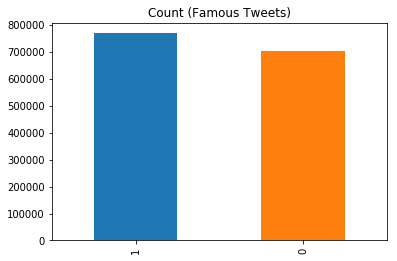

In [14]:
target_count = df.fame.value_counts()
print('Not Famous', target_count[0])
print('Famous:', target_count[1])
target_count.plot(kind='bar', title='Count (Famous Tweets)');

For the purpose of this experiment, we define 1,000,000 followers to be considered famous. It is a relatively even class distribution.  
47.83% not famous tweets  
52.17% famous tweets  

In [15]:
df_copy = df.copy()

In [16]:
for i in df_copy:
    df_copy[i] = df_copy[i].astype("category").cat.codes
    
df_copy.head()

,tweet.id,text,user,textlen,usrtweets,usrfavs,usrloc,istext,rtcnt,twtfavs,twtsrc,followers,fame
0,140829,22462,13,62,51,78,59,1,0,0,67,41,0
1,140820,11573,13,56,51,78,59,1,0,1,67,41,0
2,140819,11775,13,39,51,78,59,1,0,0,67,41,0
3,140565,41739,13,54,51,78,59,1,0,0,67,41,0
4,140471,122513,13,66,51,78,59,0,0,3,67,41,0


In [17]:
X = df_copy.drop(["fame", "tweet.id", "text", "user", "followers"], axis = 1) #remove unimportant fields
y = df_copy["fame"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 5)


In [18]:
rnd_clf = RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)
label_col = []
imp_col = []
for name, importance in zip(X.columns.values, rnd_clf.feature_importances_):
    imp_col += [importance]
    label_col += [name]
    print('{:<25}  {:1}  {:<12}'.format(name, "=", importance))

textlen                    =  0.0174616860576955
usrtweets                  =  0.19184555473443796
usrfavs                    =  0.21403112754596237
usrloc                     =  0.1456572311467535
istext                     =  0.0031157200580347855
rtcnt                      =  0.18555147738238248
twtfavs                    =  0.19953070318050778
twtsrc                     =  0.04280649989422566


The above output showed the importance of the different features. This is depicted as well in the graph below. Usrfavs, usrtweets, rtcnt, twtfavs, and usrloc we shown to be the most important features. The most interesting of which is usrloc which tells us that where someone is tweetting from is a big indication of their fame level.

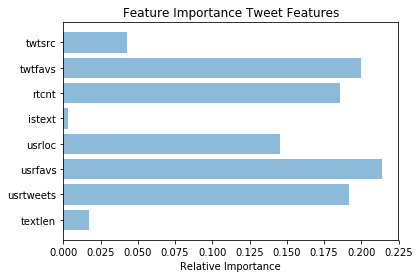

In [19]:
y_pos = np.arange(len(X.columns.values))
y_pos = np.sort(y_pos)

plt.barh(y_pos, imp_col, align='center', alpha=0.5)
plt.yticks(y_pos, label_col)
plt.xlabel('Relative Importance')
plt.title('Feature Importance Tweet Features')
 
plt.show()

In [20]:
model = RandomForestClassifier(n_estimators = 3)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

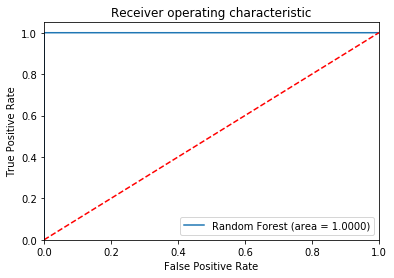

In [21]:
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.4f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

The fact that the results were perfect demonstrates the fact that twitter metadata can easily predict if a person is famous or not. This could be how Twitter helps determine if an account is verified or not.

In [92]:
X_test_rf = X_test.drop(['twtfavs','rtcnt','usrfavs','usrtweets','usrloc'], axis = 1)
X_train_rf = X_train.drop(['twtfavs','rtcnt','usrfavs','usrtweets','usrloc'], axis = 1)
# includes istext, textlen, twtsrc

# Model Creation
model = RandomForestClassifier(n_estimators = 10)
model.fit(X_train_rf, y_train)
y_pred_rf = model.predict(X_test_rf)

print("Accuracy: ", model.score(X_test_rf, y_test))

Accuracy:  0.6913499500144026


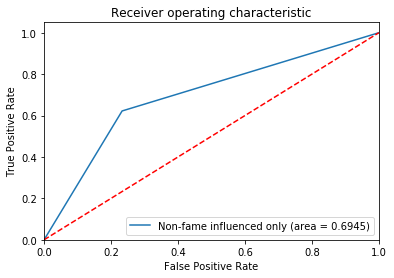

In [93]:
logit_roc_auc = roc_auc_score(y_test, y_pred_rf)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_rf)
plt.figure()
plt.plot(fpr, tpr, label='Non-fame influenced only (area = %0.4f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

The results above show that istext, textlen, twtsrc are not great predictors of someone's twitter fame

In [24]:
X_test_rf = X_test.drop(['twtsrc','usrloc','usrfavs','istext','rtcnt','twtfavs','textlen'], axis = 1)
X_train_rf = X_train.drop(['twtsrc','usrloc','usrfavs','istext','rtcnt','twtfavs','textlen'], axis = 1)

# Model Creation
model = RandomForestClassifier(n_estimators = 10)
model.fit(X_train_rf, y_train)
y_pred_rf = model.predict(X_test_rf)

print("Accuracy: ", model.score(X_test_rf, y_test))

Accuracy:  1.0


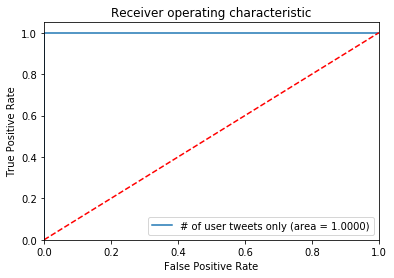

In [25]:
logit_roc_auc = roc_auc_score(y_test, y_pred_rf)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_rf)
plt.figure()
plt.plot(fpr, tpr, label='# of user tweets only (area = %0.4f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

C:\Users\EvansPC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


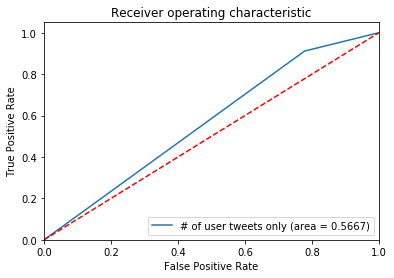

In [96]:
from  sklearn.linear_model import LogisticRegression


X_test_rf = X_test.drop(['twtsrc','usrloc','usrfavs','istext','rtcnt','twtfavs','textlen'], axis = 1)
X_train_rf = X_train.drop(['twtsrc','usrloc','usrfavs','istext','rtcnt','twtfavs','textlen'], axis = 1)

# Model Creation
lr = LogisticRegression()
lr.fit(X_train_rf, y_train)
y_pred_rf = lr.predict(X_test_rf)

logit_roc_auc = roc_auc_score(y_test, y_pred_rf)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_rf)
plt.figure()
plt.plot(fpr, tpr, label='# of user tweets only (area = %0.4f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

This shows that a logistic regression model has a much lower AUC than the Random Forests model. 

C:\Users\EvansPC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


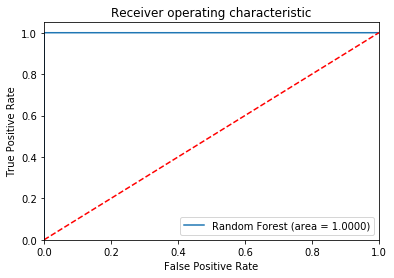

In [97]:
X_test_rf = X_test
X_train_rf = X_train

# Model Creation
lr = LogisticRegression()
lr.fit(X_train_rf, y_train)
y_pred_rf = lr.predict(X_test_rf)

logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.4f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

The above confusion matrices show that with tweet metadata it is very easy to predict if someone is famous or not (by the criteria that 1,000,000 plus followers is twitter famous). For the purposes of brevity, the model output was recorded and put into the following lists.   

The first model included:  
tweet.id	textlen	usrtweets	usrfavs	istext  
Accuracy 1.00  

The second model included:  
tweet.id	textlen	usrtweets	usrfavs	istext	rtcnt	twtfavs  
Accuracy 1.00  

The third model included:  
tweet.id	textlen	istext  
Accuracy 0.9979219524803928  

The fourth model included:  
textlen	istext  
Accuracy 0.636572956133131  

The fifth model included:  
rtcnt	twtfavs  
Accuracy 0.9579288906423241  

The sixth model included:  
usrtweets  
Accuracy 1.0  

It is relatively easy to get a score above average with twitter's metadata. We can predict that someone is famous from as little as knowing the number of tweets they have. By counting the rt's and favorities someone has we can get a 96.5% accurate model. Now we will try to ignore the metadata and see if there is anything in the content of someone's tweet that will help them achieve twitter fame.   

### Word Frequency

Below we experimented with how word frequency changes with famous and non-famous people. We took a random sample of 5000 tweets from famous and 5000 from non-famous people to compile our lists. Running the algorithm originally with all of the tweets took over 5 hours and probably wasn't ending anytime soon because the runtime is O(n^2).  

We then compare the lists of words and came up with a list of words you should tweet more!

In [63]:
famous = df[df['fame'] == 1]
not_famous = df[df['fame'] == 0]

f = famous['text']
nf = not_famous['text']

In [64]:
new_f = f.sample(5000)
new_nf = f.sample(5000)

In [65]:
f_text = []
nf_text = []

for ftext, nftext in zip(new_f, new_nf):
    f_text.extend(ftext.split(' '))
    nf_text.extend(nftext.split(' '))

In [66]:
#functions found at https://programminghistorian.org/en/lessons/counting-frequencies
def wordListToFreqDict(wordlist):
    wordfreq = [wordlist.count(p) for p in wordlist]
    return dict(zip(wordlist,wordfreq))

def sortFreqDict(freqdict):
    aux = [(freqdict[key], key) for key in freqdict]
    aux.sort()
    aux.reverse()
    return aux

In [67]:
f_freq = wordListToFreqDict(f_text)

In [68]:
nf_freq = wordListToFreqDict(nf_text)

In [89]:
fame_words = []
for key, value in f_freq.items(): 
    if value > 20 and value < 100:
        fame_words.append(key)

In [88]:
no_fame = []
for key, value in nf_freq.items(): 
    if value > 20 and value < 100:
        no_fame.append(key)

In [90]:
s_nf = set(no_fame)
common = [x for x in fame_words if x in s_nf]
common

['A',
 'very',
 'Trump',
 'No',
 '#ThorRagnarok',
 'come',
 'made',
 "I'm",
 'take',
 '❤️',
 'always',
 'If',
 'he',
 'having',
 'work',
 'available',
 'into',
 'game',
 'Good',
 'big',
 'last',
 'show',
 'year',
 'would',
 'That’s',
 'really',
 'sure',
 'her',
 'guys',
 'video',
 'actually',
 'gonna',
 'go',
 'us',
 'it’s',
 'make',
 'great',
 'only',
 'today',
 'For',
 'off',
 'every',
 'New',
 'now!',
 "It's",
 'if',
 'everyone',
 'thing',
 'It',
 'these',
 'were',
 'way',
 'how',
 'it.',
 'good',
 'where',
 'God',
 'President',
 'know',
 'think',
 'even',
 'people',
 'time',
 'miss',
 'tonight',
 'Happy',
 'look',
 'In',
 'doing',
 'some',
 'What',
 'ever',
 'then',
 'watch',
 'next',
 'see',
 'being',
 'or',
 'did',
 'shit',
 'there',
 'back',
 'should',
 'https://t.co/4Iq2qt9WVS',
 'need',
 'better',
 'fuck',
 'Love',
 'after',
 'been',
 'got',
 'first',
 'him',
 "it's",
 'don’t',
 'going',
 'they',
 'live',
 'too',
 '@realDonaldTrump',
 'Get',
 'them',
 'American',
 'those',
 'c

Above shows words that famous and non-famous people both often tweet.

Below is words that famous people tweet more often than non-famous people. 

In [91]:
s_nf = set(no_fame)
not_common = [x for x in fame_words if x not in s_nf]
not_common

['bad',
 'same',
 'put',
 'ass',
 'One',
 'days',
 'more',
 'They',
 'his',
 'MY',
 'Watch',
 'own',
 'do',
 'See',
 'start',
 'theaters',
 'old',
 'favorite',
 'lot',
 'man',
 'tickets',
 'part',
 'th…',
 'proud',
 'How',
 'must',
 'u',
 'border',
 'wanna',
 'baby',
 'Tune',
 'mom',
 'Item',
 'you’re',
 'give',
 'fun',
 'free',
 'making']

## Conclusion

When it comes to the twitter metadata usrfavs, twtfavs, rtcnt, usrtweets, and usrloc were the most important factors. Together they can create a Random Forest model that had 1.00 accuracy on our dataset of 1,475,424 tweets.

If you want to tweet words that were more often tweeted by famous people you should tweet,  
"MY mom is bad ass, Watch in theaters baby" - LOL  

For future analysis, I would want to experiment with word phrases rather than individual words. Also, I would rather run the data on a larger dataset for the word association part, but due to time constraints we were unable to do so. 